In [1]:
import sys, os
sys.path.append("/home/files/cnsi-sed")

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2
import tensorflow.keras.layers as layers
import tensorflow as tf
import numpy as np
import os

from models.layers import create_conf_head_layers, create_loc_head_layers

In [3]:
num_classes = 3

In [4]:
block1 = tf.keras.Sequential([tf.keras.layers.Conv2D(128, 1, padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU(),

                     tf.keras.layers.DepthwiseConv2D(3, strides=(2,2), padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU(),

                     tf.keras.layers.Conv2D(128, 1, padding='same'),
                     tf.keras.layers.BatchNormalization(),
                     tf.keras.layers.ReLU()])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,6,6,512]

block2 = tf.keras.Sequential([tf.keras.layers.Conv2D(128, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.DepthwiseConv2D(3, strides=(2,2), padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.Conv2D(128, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,3,3,512]
        
block3 = tf.keras.Sequential([tf.keras.layers.Conv2D(128, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.DepthwiseConv2D(3),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU(),

                    tf.keras.layers.Conv2D(128, 1, padding='same'),
                    tf.keras.layers.BatchNormalization(),
                    tf.keras.layers.ReLU()])
                    # **** conv => depthwise-conv => conv ****
                    #output1 [BN,1,1,512]

 feature extractor(mobilenet 일부, freezing) => block1(trainable) => block2(trainable) => block3(trainable) 

In [5]:
mobilenet_v2 = MobileNetV2(input_shape=(96,96,3), weights="imagenet", include_top=False)
# feature extractor
fmap12x12 = mobilenet_v2.get_layer(mobilenet_v2.layers[57].name)
feature_extractor = tf.keras.Model(inputs=[mobilenet_v2.input], outputs=[fmap12x12.output])

input_layer = tf.keras.Input(shape=(96,96,3))
x = feature_extractor(input_layer)
y1 = block1(x)
y2 = block2(y1)
y3 = block3(y2)

In [6]:
print(x.shape)
print(y1.shape)
print(y2.shape)
print(y3.shape)

(None, 12, 12, 192)
(None, 6, 6, 128)
(None, 3, 3, 128)
(None, 1, 1, 128)


In [7]:
#conf header
confs = []
conf = layers.Conv2D(4 * num_classes, kernel_size=3, padding='same')(x)
conf = tf.reshape(conf, [-1, 12*12*4,num_classes])
confs.append(conf)
conf = layers.Conv2D(6 * num_classes, kernel_size=3, padding='same')(y1)
conf = tf.reshape(conf, [-1, 6*6*6,num_classes])
confs.append(conf)
conf = layers.Conv2D(6 * num_classes, kernel_size=3, padding='same')(y2)
conf = tf.reshape(conf, [-1, 3*3*6,num_classes])
confs.append(conf)
conf = layers.Conv2D(4 * num_classes, kernel_size=1)(y3)
conf = tf.reshape(conf, [-1, 1*1*4,num_classes])
confs.append(conf)


#location header
locs = []
loc = layers.Conv2D(4 * 4, kernel_size=3, padding='same')(x)
loc = tf.reshape(loc, [-1, 12*12*4,4])
locs.append(loc)
loc = layers.Conv2D(6 * 4, kernel_size=3, padding='same')(y1)
loc = tf.reshape(loc, [-1, 6*6*6,4])
locs.append(loc)
loc = layers.Conv2D(6 * 4, kernel_size=3, padding='same')(y2)
loc = tf.reshape(loc, [-1, 3*3*6,4])
locs.append(loc)
loc = layers.Conv2D(4 * 4, kernel_size=1)(y3)
loc = tf.reshape(loc, [-1, 1*1*4,4])
locs.append(loc)

confs = tf.concat(confs, axis=-2)
locs = tf.concat(locs, axis=-2)

In [8]:
mobilenet_ssd = tf.keras.Model(inputs=[input_layer], outputs=[confs,locs])

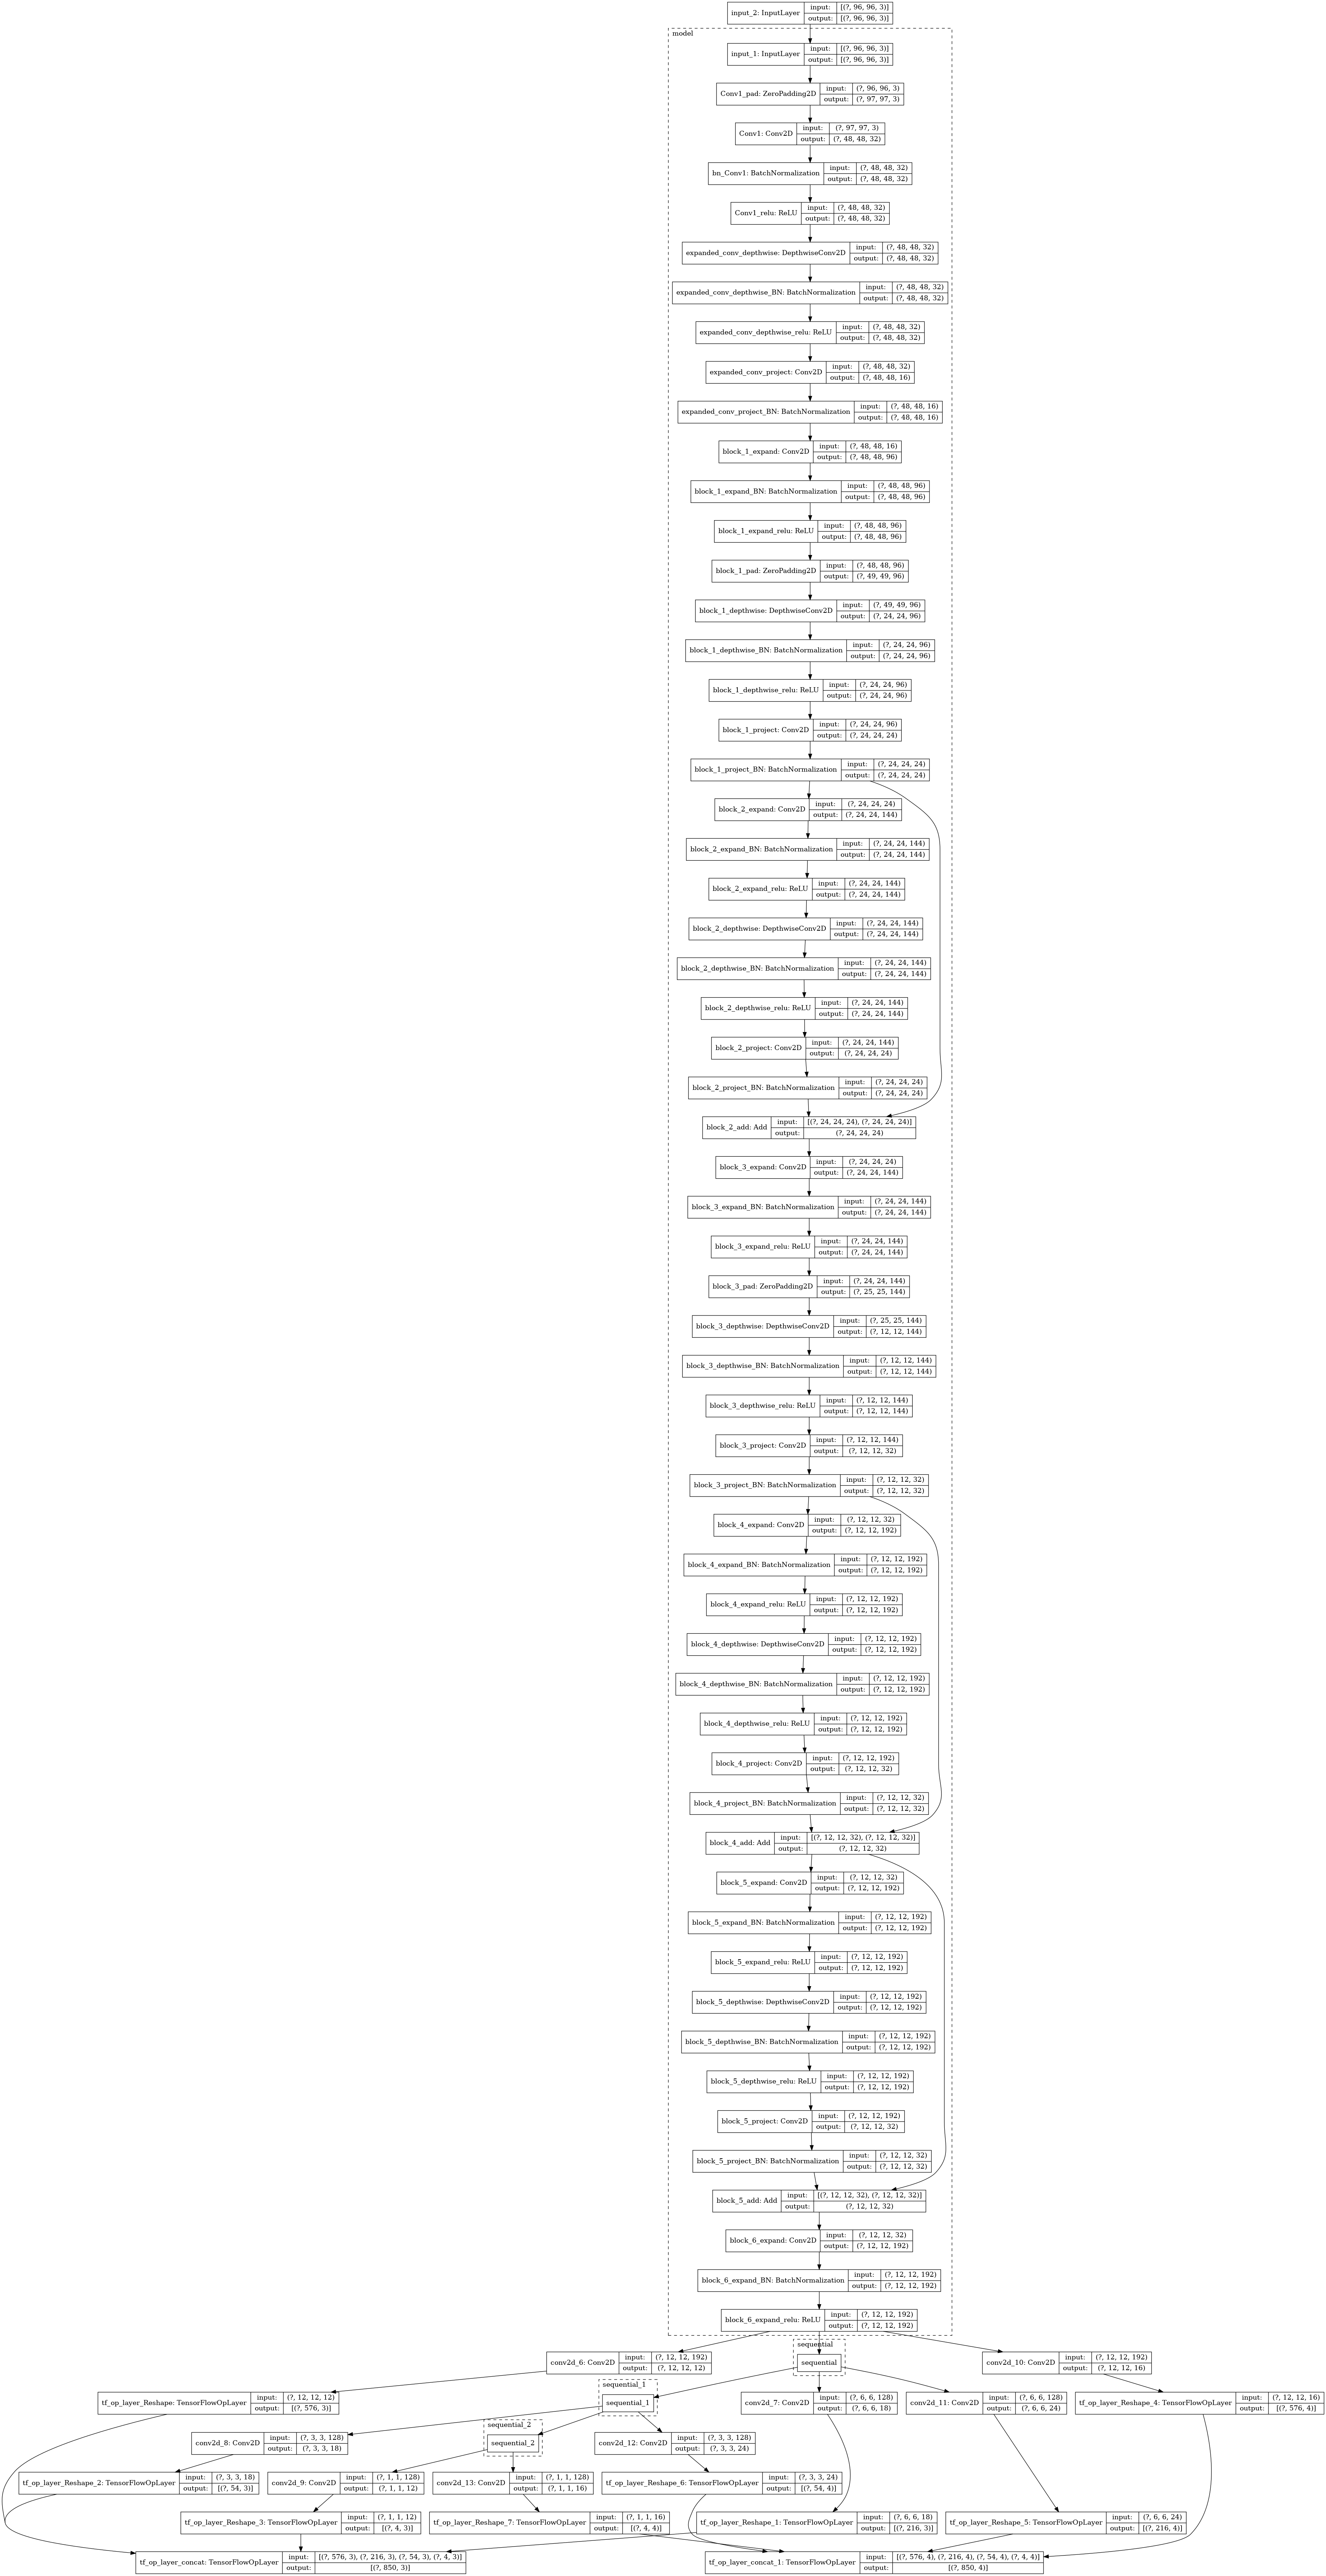

In [9]:
tf.keras.utils.plot_model(mobilenet_ssd, show_shapes=True, expand_nested=True)

In [10]:
mobilenet_ssd.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 12, 12, 192)  65920       input_2[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 6, 6, 128)    44032       model[1][0]                      
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 3, 3, 128)    35840       sequential[0][0]                 
____________________________________________________________________________________________

In [11]:
mobilenet_ssd.layers

In [12]:
mobilenet_ssd.save("ssd-mobile-shallow-96-c3")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ssd-mobile-shallow-96-c3/assets
